In [1]:
import os

os.chdir("../..")

In [2]:
%load_ext autoreload
%autoreload 2

from mars import db
from mars.models_training import datasets
from mars.db import db_fields, collections
from mars import similarity_calculation
from mars.sentence_embeddings import score_embeddings_for_documents, embedd_sentences

2021-12-01 18:13:27.177580: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-01 18:13:27.177623: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-12-01 18:13:30.658081: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-01 18:13:30.658134: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-01 18:13:30.658154: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-8E43FDR): /proc/driver/nvidia/version does not exist
2021-12-01 18:13:30.658349: I tensorflow/core/platform/cpu_fe

In [3]:
DOC_ID = "Documents/1728"

In [4]:
target_sents = datasets.targets[datasets.DocumentLevelDataset.jobin2019]

In [5]:
target_sents

['Transparency',
 'Justice, fairness, and equity',
 'Non-maleficence',
 'Responsibility and accountability',
 'Privacy',
 'Beneficence',
 'Freedom and autonomy',
 'Trust',
 'Sustainability',
 'Dignity',
 'Solidarity']

In [ ]:
similarity_calculation.infer_issues_for_documents(1728, 1728, db_fields.EmbeddingType.LABSE, target_sents)

In [13]:
sents = [d for d in collections.sentences.fetchByExample({db_fields.DOC_ID:DOC_ID}, 1000)]

In [14]:
d = []
for sent in sents:
    issues = sent['issues']['labse'].getStore()
    issues['sentence']=sent[db_fields.SENTENCE]
    issues['sentenceNumber']=sent[db_fields.SENTENCE_NUMBER]
    issues['paragraphNumber']=sent[db_fields.SEQUENCE_NUMBER]
    d.append(issues)
import pandas as pd


df = pd.DataFrame(d).set_index(['paragraphNumber', 'sentenceNumber'])

In [27]:
df_melt= df.set_index('sentence').melt()

In [28]:
df_melt.head()

,variable,value
0,Transparency,0.023070
1,Transparency,0.042661
2,Transparency,0.053751
3,Transparency,0.320218
4,Transparency,0.049213


/home/sgizinski/repos/AI-strategies-papers-regulations-monitoring/.venv/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 38'. Pick better value with 'binwidth'.


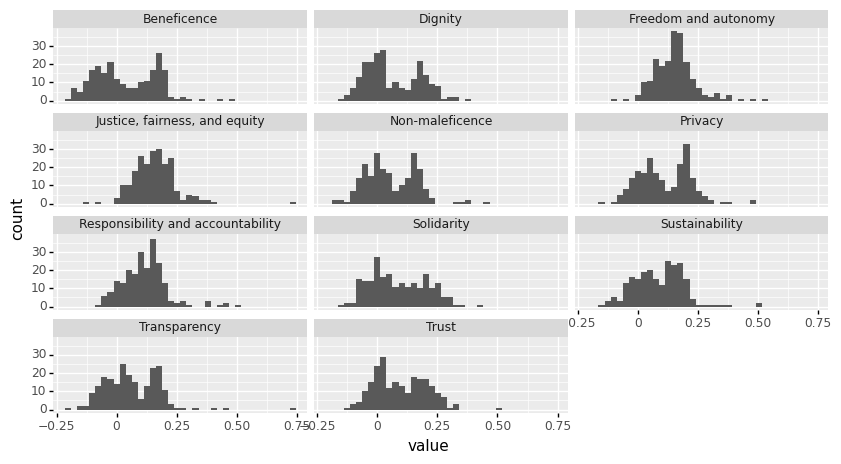

<ggplot: (8731019115855)>

In [39]:
import plotly.express as px
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap,geom_histogram, facet_grid
import plotnine
plotnine.options.figure_size=(10,5)
(ggplot(df_melt, aes('value'))
 + geom_histogram()
 + facet_wrap('~variable', ncol=3))

In [ ]:
for target in target_sents:
    px.histogram(df[target]).show()

In [47]:
maxes = df[target_sents].max()
for issue, value in maxes.items():
    if value>.5:
        print(f"'{issue}'", 'top sentence:',"'",df[df[issue]==value]['sentence'].iloc[0],"'")
        print("Score:", value)

'Transparency' top sentence: '    Transparency        '
Score: 0.7382491827255323
'Justice, fairness, and equity' top sentence: '    Diversity, non-discrimination and fairness        '
Score: 0.7417867757961945
'Freedom and autonomy' top sentence: '    Diversity, non-discrimination and fairness        '
Score: 0.5215069694371237
'Trust' top sentence: ' Referral '
Score: 0.5077001381037993
'Sustainability' top sentence: '    Accountability        '
Score: 0.5069328493284877


In [42]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

In [43]:
import numpy as np

ISSUE = 'Responsibility and accountability'
data = df[[ISSUE, 'sentence']].reset_index(drop=True).copy()
data[ISSUE]=moving_average(data[ISSUE],5)

In [46]:
px.line(data, y=ISSUE, hover_data=['sentence'], template='ggplot2').write_html("reponsibility_in_sentences.html")